# 1. Data Loading

### 1.1 Create PyTorch Datasets and DataLoaders

In [1]:
# Load autoreload extension
%load_ext autoreload
# Set autoreload to mode 2
%autoreload 2

# Import required libraries
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm

# PyTorch libraries
import torch
from torch.utils.data import DataLoader
import wandb

from utils.data_persistence import load_scalers
from utils.plot_utils import plot_training_history, plot_evaluation_metrics
from utils.wandb_utils import setup_wandb
from utils.training_utils import train_model, evaluate_model

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# ========== Model training hyperparameters =========
PATIENCE = 10
LR = 0.001
DEBUG_MODE = True

if DEBUG_MODE:
    # Local development settings (to check if the code is working)
    N_EPOCHS = 10
    BATCH_SIZE = 64
    NUM_WORKERS = 4
else:
    # Remote server settings (to train the model, recommend using Otter lab machine)
    N_EPOCHS = 100
    BATCH_SIZE = 2 ** 14   # = 16384
    NUM_WORKERS = 16

# ================= Wandb settings =============
USE_WANDB = True
WANDB_USERNAME = "tin-hoang"
WANDB_PROJECT = "EEEM073-Solar-Radiation"

# =========== Time series hyperparameters ===========
LOOKBACK = 24

# List of available features to use (Himawari-7)
AVAILABLE_FEATURES = [
    'ghi',                     # Target variable
    'air_temperature',         # Weather features
    'wind_speed',
    'relative_humidity',
    'dew_point',
    'surface_pressure',
    'total_precipitable_water',
    'cloud_type',              # Cloud features
    'cloud_fill_flag',
    'cld_opd_dcomp',
    'cld_press_acha',
    'cld_reff_dcomp',
    'clearsky_ghi',            # Clear sky estimates
    'clearsky_dni',
    'clearsky_dhi',
    'solar_zenith_angle',      # Solar geometry
    'surface_albedo',          # Surface properties
    'ozone',                   # Atmospheric properties
    'aod',
    'ssa',
    'asymmetry',
    'alpha'
]

# Choose features to use in modeling
SELECTED_FEATURES = [
    'air_temperature',
    'wind_speed',
    'relative_humidity',
    'cloud_type',
    'solar_zenith_angle',
    'clearsky_ghi',
    'total_precipitable_water',
    'surface_albedo'
]

# Target variable
TARGET_VARIABLE = 'ghi'


Using cuda device


In [2]:
from utils.data_persistence import load_normalized_data

train_preprocessed_data_path = "data/processed/train_normalized.h5"
val_preprocessed_data_path = "data/processed/val_normalized.h5"
test_preprocessed_data_path = "data/processed/test_normalized.h5"

# Load sequences
train_data, metadata = load_normalized_data(train_preprocessed_data_path)

scaler_path = "data/processed/model_scalers.pkl"
scalers = load_scalers(scaler_path)

# Print metadata
print(f"Train set | Metadata: {metadata}")
# Print created time
print(f"Train set | Created time: {metadata['created_time'] if 'created_time' in metadata else 'No created time'}")
# Print raw files
print(f"Train set | Raw files: {metadata['raw_files'] if 'raw_files' in metadata else 'No raw files'}")

# Print data structure and shape
print(f"Train set | Data structure:")
for key, value in train_data.items():
    print(f"  {key} shape: {value.shape}")


Loaded normalized data from data/processed/train_normalized.h5
Loaded 12 scalers from data/processed/model_scalers.pkl
Train set | Metadata: {'created_time': '2025-04-25 06:06:18'}
Train set | Created time: 2025-04-25 06:06:18
Train set | Raw files: No raw files
Train set | Data structure:
  air_temperature shape: (70128, 105)
  clearsky_ghi shape: (70128, 105)
  cloud_type shape: (70128, 105)
  coordinates shape: (105, 2)
  elevation shape: (105,)
  ghi shape: (70128, 105)
  nighttime_mask shape: (70128, 105)
  relative_humidity shape: (70128, 105)
  solar_zenith_angle shape: (70128, 105)
  surface_albedo shape: (70128, 105)
  time_features shape: (70128, 8)
  total_precipitable_water shape: (70128, 105)
  wind_speed shape: (70128, 105)


In [23]:
from utils.timeseriesdataset import TimeSeriesDataset

# Create datasets
train_dataset = TimeSeriesDataset(train_preprocessed_data_path, lookback=LOOKBACK)
val_dataset = TimeSeriesDataset(val_preprocessed_data_path, lookback=LOOKBACK)
test_dataset = TimeSeriesDataset(test_preprocessed_data_path, lookback=LOOKBACK)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Check sample batch
sample_batch = next(iter(train_loader))
for key, value in sample_batch.items():
    if isinstance(value, torch.Tensor):
        print(f"{key} shape: {value.shape}")


Loaded normalized data from data/processed/train_normalized.h5
Loaded normalized data file (1/1): data/processed/train_normalized.h5
Loaded data with 13 features
Temporal features: ['time_features']
Static features: ['coordinates', 'elevation']
Time series features: ['air_temperature', 'clearsky_ghi', 'cloud_type', 'ghi', 'nighttime_mask', 'relative_humidity', 'solar_zenith_angle', 'surface_albedo', 'total_precipitable_water', 'wind_speed']
Dataset dimensions: 70128 timesteps, 105 locations
Dataset contains 7360920 possible samples
Loaded normalized data from data/processed/val_normalized.h5
Loaded normalized data file (1/1): data/processed/val_normalized.h5
Loaded data with 13 features
Temporal features: ['time_features']
Static features: ['coordinates', 'elevation']
Time series features: ['air_temperature', 'clearsky_ghi', 'cloud_type', 'ghi', 'nighttime_mask', 'relative_humidity', 'solar_zenith_angle', 'surface_albedo', 'total_precipitable_water', 'wind_speed']
Dataset dimensions: 8

In [4]:
# Get a batch to determine input dimensions
batch = next(iter(train_loader))

# Method 1: Extract dimensions from a batch (more reliable)
temporal_features = batch['temporal_features']
static_features = batch['static_features']

# Check if we have 3D temporal features (batch, seq_len, features)
if len(temporal_features.shape) == 3:
    temporal_dim = temporal_features.shape[2]
else:
    # Handle 2D temporal features (batch, features)
    temporal_dim = temporal_features.shape[1]

static_dim = static_features.shape[1]

print(f"  Input dimensions determined from batch:")
print(f"  - Temporal dimension: {temporal_dim}")
print(f"  - Static dimension: {static_dim}")


  Input dimensions determined from batch:
  - Temporal dimension: 8
  - Static dimension: 2


## 2. Model Training Setup

## 2.1 Import utils

In [5]:
from torchinfo import summary

from utils.training_utils import train_model, evaluate_model
from utils.wandb_utils import is_wandb_enabled, set_wandb_flag, set_keep_run_open
from utils.model_utils import print_model_info

# Enable wandb tracking
set_wandb_flag(USE_WANDB)
# Keep the wandb run open after training to continue logging evaluation plots
set_keep_run_open(True)


## 2.2 Define Experiment Pipeline

In [6]:
def run_experiment_pipeline(model, train_loader, val_loader, test_loader, model_name, epochs=30, patience=5, lr=0.001):
    """
    Run the experiment pipeline for a given model.

    Args:
        model: The model to train.
        train_loader: The training data loader.
        val_loader: The validation data loader.
        test_loader: The test data loader.
        model_name: The name of the model.
        epochs: The number of epochs to train the model.
        patience: The number of epochs to wait before early stopping.
        lr: The learning rate for the model.
    """
    history, val_metrics, test_metrics = None, None, None

    try:
        print(f"Training {model_name} model...")
        history = train_model(
            model,
            train_loader,
            val_loader,
            model_name=model_name,
            epochs=epochs,
            patience=patience,
            lr=lr,
            debug_mode=DEBUG_MODE
        )
        training_plot = plot_training_history(history, model_name=model_name)

        print(f"Evaluating {model_name} model on validation set...")
        val_metrics = evaluate_model(
            model,
            val_loader,
            scalers[f'{TARGET_VARIABLE}_scaler'],
            model_name=f"{model_name} - Validation"
        )
        val_plot = plot_evaluation_metrics(val_metrics, model_name=f"{model_name} - Validation")

        print(f"\nEvaluating {model_name} model on test set...")
        test_metrics = evaluate_model(
            model,
            test_loader,
            scalers[f'{TARGET_VARIABLE}_scaler'],
            model_name=f"{model_name} - Test"
        )
        test_plot = plot_evaluation_metrics(test_metrics, model_name=f"{model_name} - Test")

        # Log the test plot to wandb
        if is_wandb_enabled():
            wandb.log({"plots/history_plot": wandb.Image(training_plot)})
            wandb.log({"plots/predictions_plot": wandb.Image(val_plot)})
            wandb.log({"plots/predictions_plot": wandb.Image(test_plot)})

        # Save the model
        torch.save(model.state_dict(), f'{model_name}_best.pt')

    finally:
        # Finish wandb run if it's still open
        if is_wandb_enabled():
            wandb.finish()

        # Clear GPU memory
        torch.cuda.empty_cache()

    return history, val_metrics, test_metrics


# 3. Model Experiments

### 3.1 Temporal Convolutional Networks (TCN) Model

TCNs are specialized convolutional architectures for sequence modeling that combine the best of CNNs and RNNs. The key features include:

- **Causal Convolutions**: Each output only depends on current and past inputs.
- **Dilated Convolutions**: Captures larger effective history with fewer parameters.
- **Residual Connections**: Helps with training deep networks and information flow.

TCNs can capture long-range patterns in time series data efficiently, making them suitable for solar radiation forecasting where both short-term weather fluctuations and longer-term patterns matter.

In [7]:
from models.tcn import TCNModel

# Create TCN model
tcn_model = TCNModel(
    input_dim=temporal_dim,
    static_dim=static_dim,
    num_channels=[64, 128, 128, 64],  # Number of channels in each layer
    kernel_size=3,                    # Size of the convolutional kernel
    dropout=0.2,                      # Dropout rate
).to(device)

# Print the model
print_model_info(tcn_model)


Model: TCNModel
Total parameters: 264,993
Trainable parameters: 264,993
Non-trainable parameters: 0

Model structure:
TCNModel(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(8, 64, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.2, inplace=False)
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.2, inplace=False)
        (net): Sequential(
          (0): Conv1d(8, 64, kernel_size=(3,), stride=(1,), padding=(2,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
          (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.2, inplace=False)
        )
        (downsample): Conv1d(8, 64, kernel_size=(1,), stride=(1,))

/user/HS402/th01167/.venv/master/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Training TCN model...
track_experiment: USE_WANDB=True, wandb.run=None, keep_run_open=True
Creating new wandb run for TCN


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tin-hoang to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/100


Epoch 1/100 | Train Loss: 0.0373, Train MAE: 0.1319 | Val Loss: 0.0083, Val MAE: 0.0524 | LR: 0.000500
Epoch 2/100


Epoch 2/100 | Train Loss: 0.0117, Train MAE: 0.0660 | Val Loss: 0.0083, Val MAE: 0.0517 | LR: 0.000500
Epoch 3/100


Epoch 3/100 | Train Loss: 0.0108, Train MAE: 0.0594 | Val Loss: 0.0080, Val MAE: 0.0496 | LR: 0.000500
Epoch 4/100


Epoch 4/100 | Train Loss: 0.0105, Train MAE: 0.0568 | Val Loss: 0.0080, Val MAE: 0.0474 | LR: 0.000500
Epoch 5/100


Epoch 5/100 | Train Loss: 0.0104, Train MAE: 0.0554 | Val Loss: 0.0083, Val MAE: 0.0483 | LR: 0.000500
Epoch 6/100


Epoch 6/100 | Train Loss: 0.0102, Train MAE: 0.0547 | Val Loss: 0.0084, Val MAE: 0.0488 | LR: 0.000500
Epoch 7/100


Epoch 7/100 | Train Loss: 0.0101, Train MAE: 0.0543 | Val Loss: 0.0079, Val MAE: 0.0472 | LR: 0.000500
Epoch 8/100


Epoch 8/100 | Train Loss: 0.0100, Train MAE: 0.0543 | Val Loss: 0.0084, Val MAE: 0.0484 | LR: 0.000500
Epoch 9/100


Epoch 9/100 | Train Loss: 0.0099, Train MAE: 0.0542 | Val Loss: 0.0078, Val MAE: 0.0466 | LR: 0.000500
Epoch 10/100


Epoch 10/100 | Train Loss: 0.0098, Train MAE: 0.0542 | Val Loss: 0.0082, Val MAE: 0.0481 | LR: 0.000500
Epoch 11/100


Epoch 11/100 | Train Loss: 0.0097, Train MAE: 0.0543 | Val Loss: 0.0081, Val MAE: 0.0469 | LR: 0.000500
Epoch 12/100


Epoch 12/100 | Train Loss: 0.0096, Train MAE: 0.0543 | Val Loss: 0.0081, Val MAE: 0.0459 | LR: 0.000500
Epoch 13/100


Epoch 13/100 | Train Loss: 0.0096, Train MAE: 0.0544 | Val Loss: 0.0084, Val MAE: 0.0479 | LR: 0.000500
Epoch 14/100


Epoch 14/100 | Train Loss: 0.0095, Train MAE: 0.0544 | Val Loss: 0.0082, Val MAE: 0.0464 | LR: 0.000500
Epoch 15/100


Epoch 15/100 | Train Loss: 0.0094, Train MAE: 0.0544 | Val Loss: 0.0081, Val MAE: 0.0462 | LR: 0.000250
Epoch 16/100


Epoch 16/100 | Train Loss: 0.0093, Train MAE: 0.0542 | Val Loss: 0.0085, Val MAE: 0.0474 | LR: 0.000250
Epoch 17/100


Epoch 17/100 | Train Loss: 0.0093, Train MAE: 0.0541 | Val Loss: 0.0087, Val MAE: 0.0488 | LR: 0.000250
Epoch 18/100


Epoch 18/100 | Train Loss: 0.0092, Train MAE: 0.0540 | Val Loss: 0.0084, Val MAE: 0.0470 | LR: 0.000250
Epoch 19/100


Epoch 19/100 | Train Loss: 0.0092, Train MAE: 0.0539 | Val Loss: 0.0085, Val MAE: 0.0474 | LR: 0.000250
Early stopping at epoch 19
LOADING BEST MODEL FROM TRAINING SESSION
Keeping wandb run open as requested (keep_run_open=True)


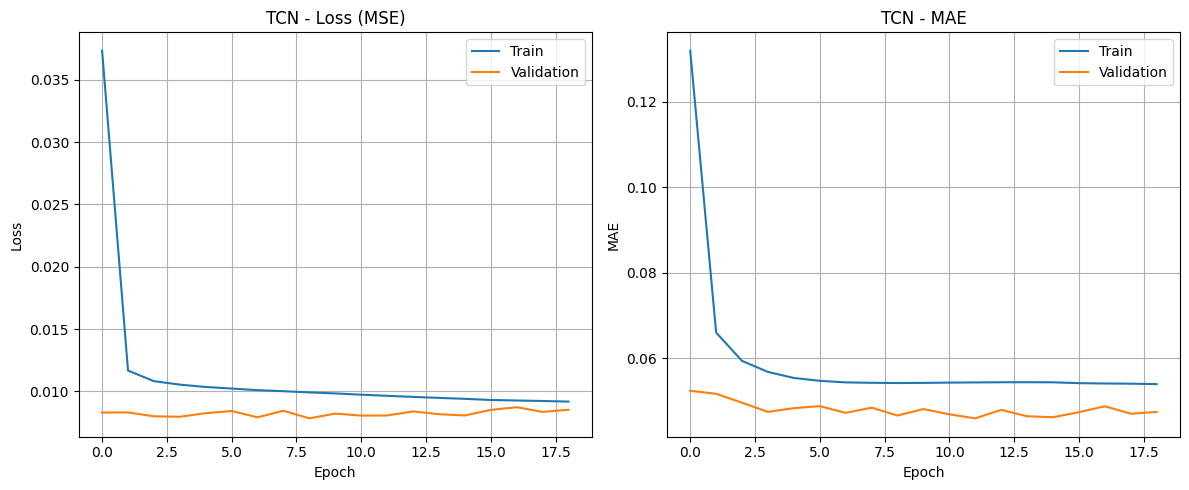

Evaluating TCN model on validation set...

TCN - Validation Evaluation Metrics:
  Overall:  MSE: 10044.90, RMSE: 100.22, MAE: 51.81, R²: 0.8943
  Daytime:  MSE: 20120.54, RMSE: 141.85, MAE: 101.95, R²: 0.7577
  Nighttime: MSE: 10.77, RMSE: 3.28, MAE: 1.89, R²: -3.2449
  Inference Speed: 8385723.17 samples/sec, 0.0001 ms/sample
  Total time: 0.0215 sec for 180224 samples

Evaluating TCN model on test set...

TCN - Test Evaluation Metrics:
  Overall:  MSE: 8904.00, RMSE: 94.36, MAE: 48.51, R²: 0.9065
  Daytime:  MSE: 17836.24, RMSE: 133.55, MAE: 95.28, R²: 0.7903
  Nighttime: MSE: 12.89, RMSE: 3.59, MAE: 1.95, R²: -4.2387
  Inference Speed: 9755494.46 samples/sec, 0.0001 ms/sample
  Total time: 0.0185 sec for 180224 samples


test/inference_speed_samples_per_sec,▁
test/inference_time_ms_per_sample,▁
test/mae,▁
test/mse,▁
test/r2,▁
test/rmse,▁
train/epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
train/learning_rate,██████████████▁▁▁▁▁
train/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██


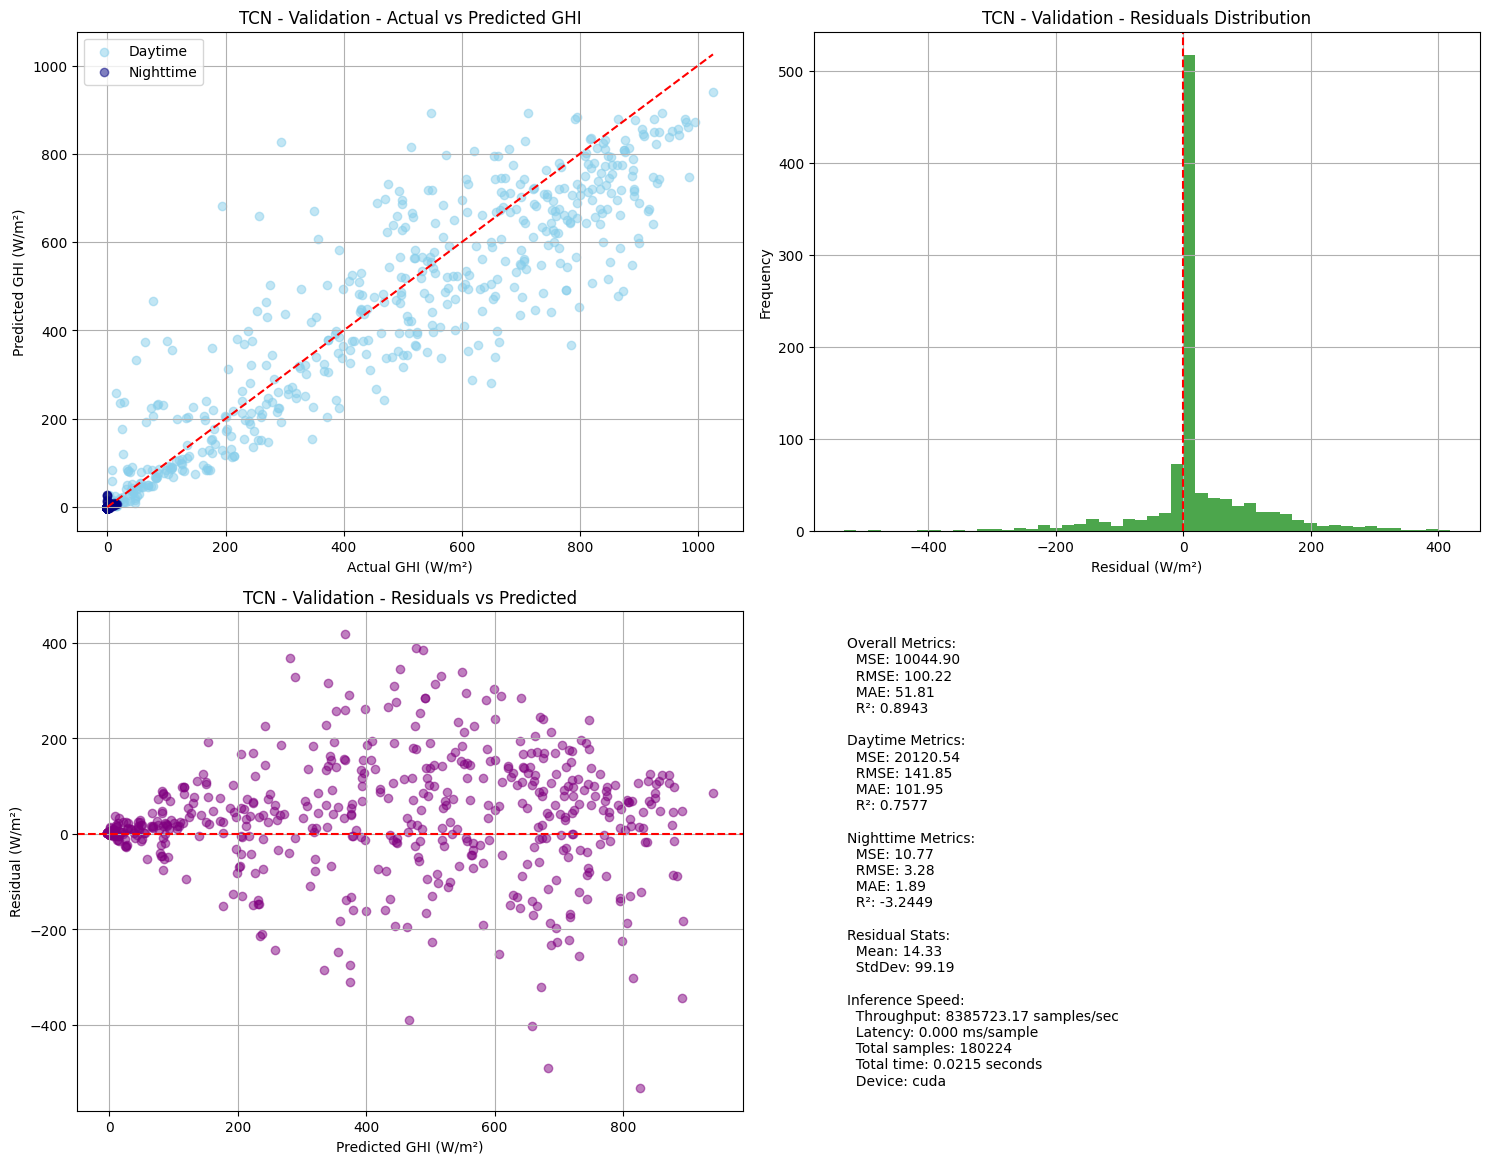

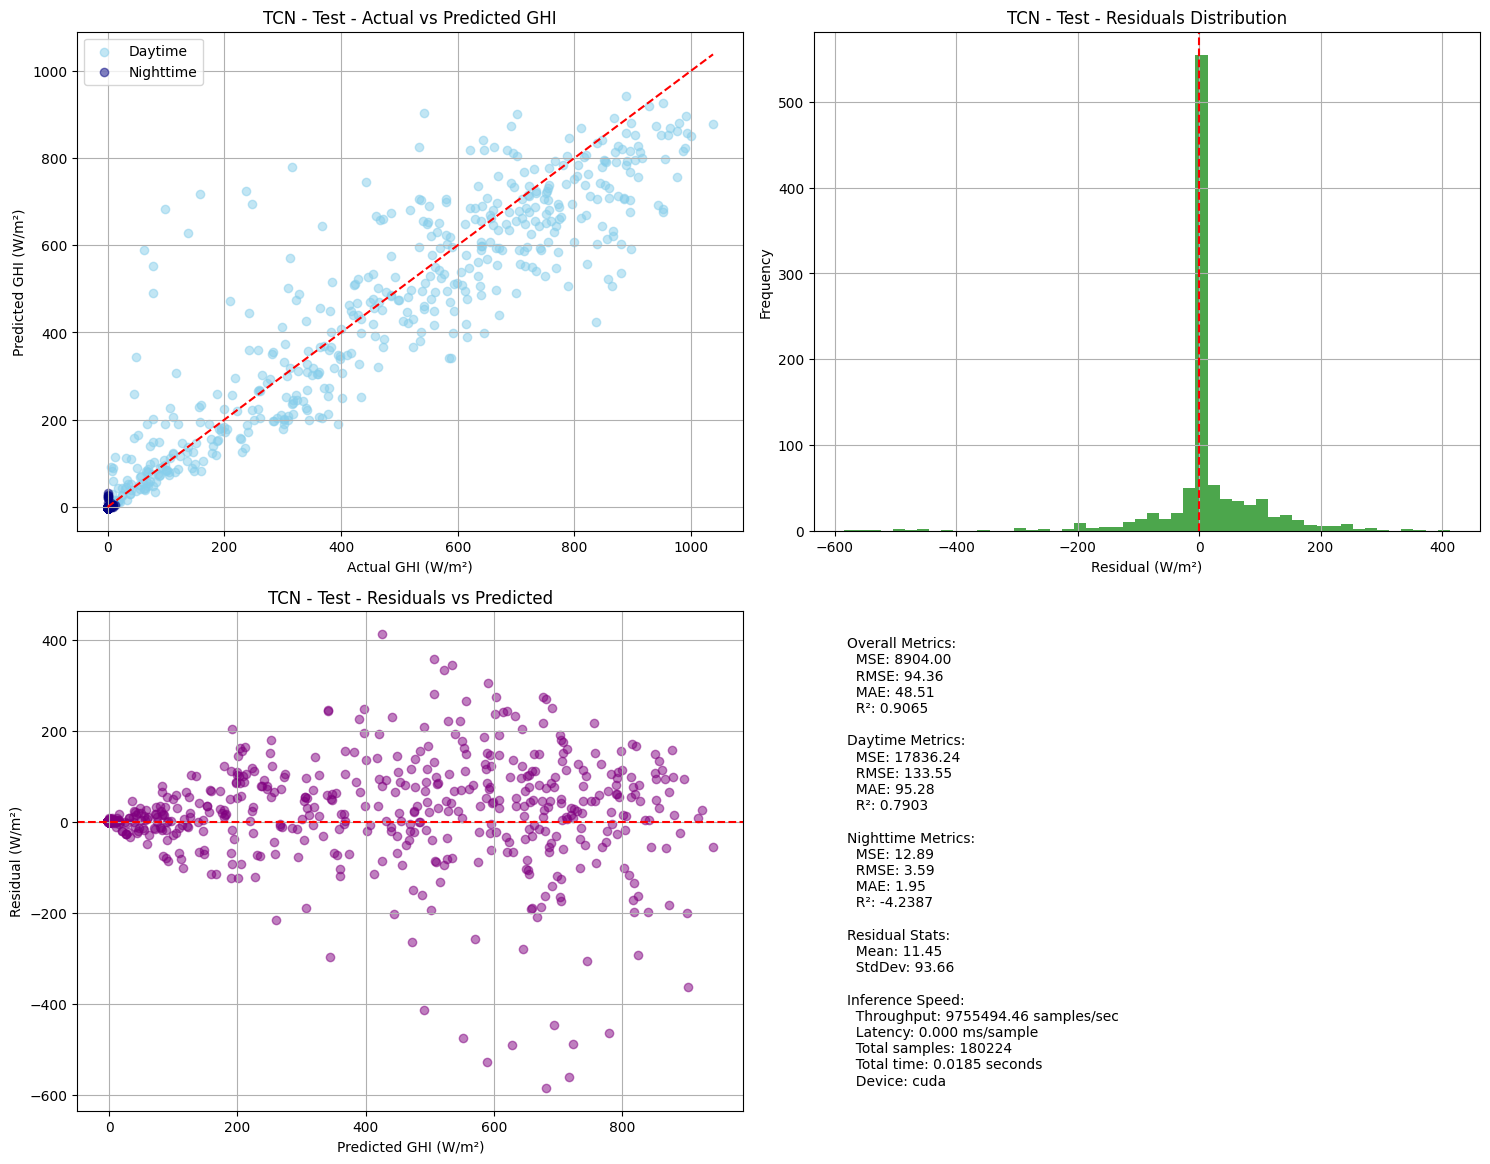

In [8]:
model_name = "TCN"

# Train the TCN model
tcn_history, tcn_val_metrics, tcn_test_metrics = run_experiment_pipeline(
    tcn_model,
    train_loader,
    val_loader,
    test_loader,
    model_name=model_name,
    epochs=N_EPOCHS,
    patience=PATIENCE,
    lr=LR
)


### 3.2 Transformer Model

Transformers revolutionized natural language processing and have been adapted for time series forecasting with impressive results. Their key advantages include:

- **Self-Attention Mechanism**: Allows the model to weight the importance of different input time steps dynamically.
- **Parallelization**: Can process the entire sequence in parallel, unlike RNNs.
- **Long-range Dependencies**: Captures dependencies at arbitrary distances in the sequence.

For solar forecasting, Transformers can identify complex temporal patterns across different time scales and account for both short-term and long-term relationships in the weather and solar data.

In [20]:
from models.transformer import TransformerModel

# Create Transformer model
transformer_model = TransformerModel(
    input_dim=temporal_dim,           # Dimension of input features
    static_dim=static_dim,            # Dimension of static features
    d_model=128,                      # Transformer model dimension
    nhead=8,                          # Number of attention heads
    num_layers=4,                     # Number of transformer layers
    dim_feedforward=512,              # Dimension of feedforward network
    dropout=0.2,                      # Dropout rate
).to(device)

# Print the model
print_model_info(transformer_model)


Model: TransformerModel
Total parameters: 807,265
Trainable parameters: 807,265
Non-trainable parameters: 0

Model structure:
TransformerModel(
  (input_projection): Linear(in_features=8, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (bn_transformer): BatchNor

model_architecture,TransformerModel( ...


Training Transformer model...
track_experiment: USE_WANDB=True, wandb.run=None, keep_run_open=True
Creating new wandb run for Transformer


Epoch 1/100


Epoch 1/100 | Train Loss: 0.0283, Train MAE: 0.1118 | Val Loss: 0.0075, Val MAE: 0.0494 | LR: 0.000250
Epoch 2/100


Epoch 2/100 | Train Loss: 0.0117, Train MAE: 0.0658 | Val Loss: 0.0084, Val MAE: 0.0563 | LR: 0.000250
Epoch 3/100


Epoch 3/100 | Train Loss: 0.0110, Train MAE: 0.0616 | Val Loss: 0.0074, Val MAE: 0.0493 | LR: 0.000250
Epoch 4/100


Epoch 4/100 | Train Loss: 0.0107, Train MAE: 0.0605 | Val Loss: 0.0077, Val MAE: 0.0458 | LR: 0.000250
Epoch 5/100


Epoch 5/100 | Train Loss: 0.0106, Train MAE: 0.0603 | Val Loss: 0.0081, Val MAE: 0.0483 | LR: 0.000250
Epoch 6/100


Epoch 6/100 | Train Loss: 0.0104, Train MAE: 0.0604 | Val Loss: 0.0078, Val MAE: 0.0461 | LR: 0.000250
Epoch 7/100


Epoch 7/100 | Train Loss: 0.0104, Train MAE: 0.0609 | Val Loss: 0.0136, Val MAE: 0.0728 | LR: 0.000250
Epoch 8/100


Epoch 8/100 | Train Loss: 0.0103, Train MAE: 0.0607 | Val Loss: 0.0086, Val MAE: 0.0499 | LR: 0.000250
Epoch 9/100


Epoch 9/100 | Train Loss: 0.0101, Train MAE: 0.0602 | Val Loss: 0.0087, Val MAE: 0.0499 | LR: 0.000125
Epoch 10/100


Epoch 10/100 | Train Loss: 0.0100, Train MAE: 0.0599 | Val Loss: 0.0086, Val MAE: 0.0488 | LR: 0.000125
Epoch 11/100


Epoch 11/100 | Train Loss: 0.0099, Train MAE: 0.0598 | Val Loss: 0.0086, Val MAE: 0.0491 | LR: 0.000125
Epoch 12/100


Epoch 12/100 | Train Loss: 0.0099, Train MAE: 0.0596 | Val Loss: 0.0088, Val MAE: 0.0502 | LR: 0.000125
Epoch 13/100


Epoch 13/100 | Train Loss: 0.0098, Train MAE: 0.0594 | Val Loss: 0.0088, Val MAE: 0.0492 | LR: 0.000125
Early stopping at epoch 13
LOADING BEST MODEL FROM TRAINING SESSION
Keeping wandb run open as requested (keep_run_open=True)


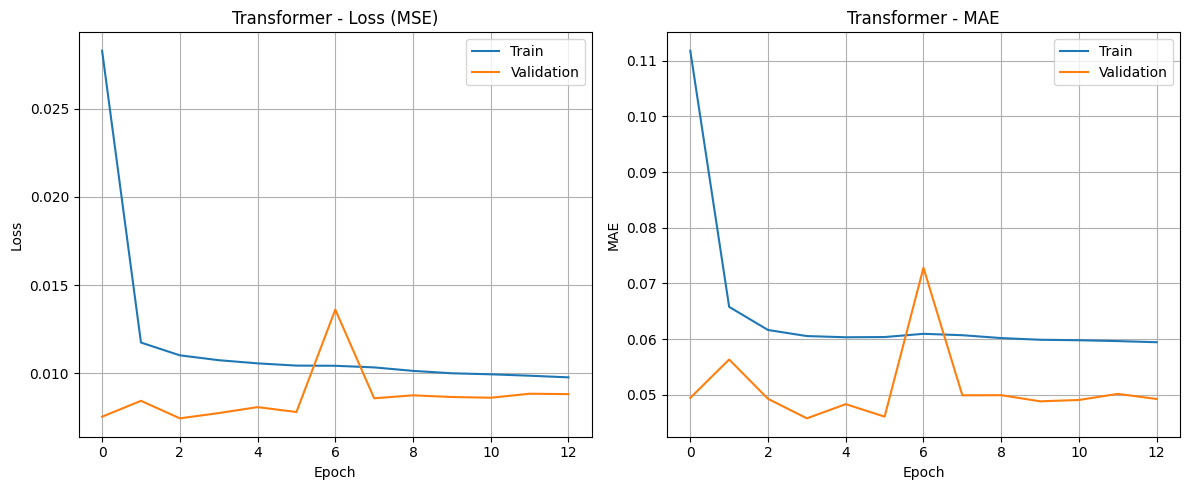

Evaluating Transformer model on validation set...

Transformer - Validation Evaluation Metrics:
  Overall:  MSE: 10299.66, RMSE: 101.49, MAE: 52.98, R²: 0.8934
  Daytime:  MSE: 20650.93, RMSE: 143.70, MAE: 103.27, R²: 0.7543
  Nighttime: MSE: 9.32, RMSE: 3.05, MAE: 2.98, R²: -2.6116
  Inference Speed: 6119375.72 samples/sec, 0.0002 ms/sample
  Total time: 0.0147 sec for 90112 samples

Evaluating Transformer model on test set...

Transformer - Test Evaluation Metrics:
  Overall:  MSE: 9256.44, RMSE: 96.21, MAE: 49.99, R²: 0.9040
  Daytime:  MSE: 18562.07, RMSE: 136.24, MAE: 97.29, R²: 0.7832
  Nighttime: MSE: 9.29, RMSE: 3.05, MAE: 2.98, R²: -2.7085
  Inference Speed: 6182639.57 samples/sec, 0.0002 ms/sample
  Total time: 0.0146 sec for 90112 samples


test/inference_speed_samples_per_sec,▁
test/inference_time_ms_per_sample,▁
test/mae,▁
test/mse,▁
test/r2,▁
test/rmse,▁
train/epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
train/learning_rate,████████▁▁▁▁▁
train/loss,█▂▁▁▁▁▁▁▁▁▁▁▁
train/mae,█▂▁▁▁▁▁▁▁▁▁▁▁
val/epoch,▁▂▂▃▃▄▅▅▆▆▇▇█


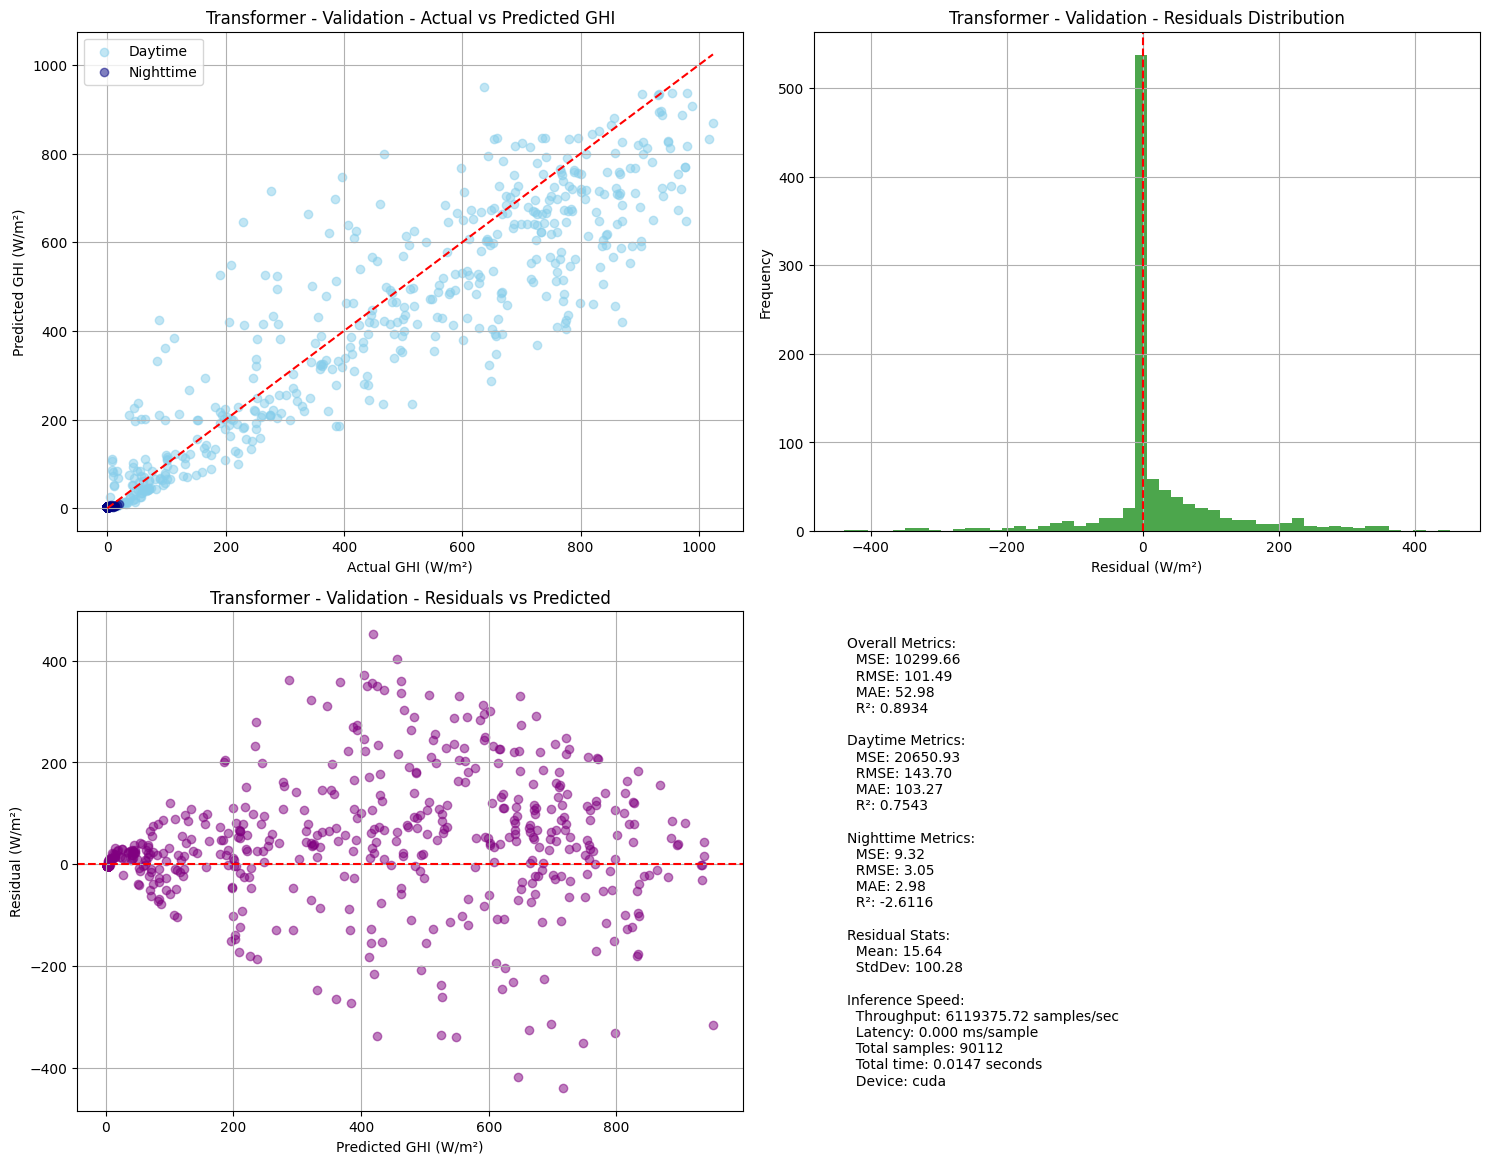

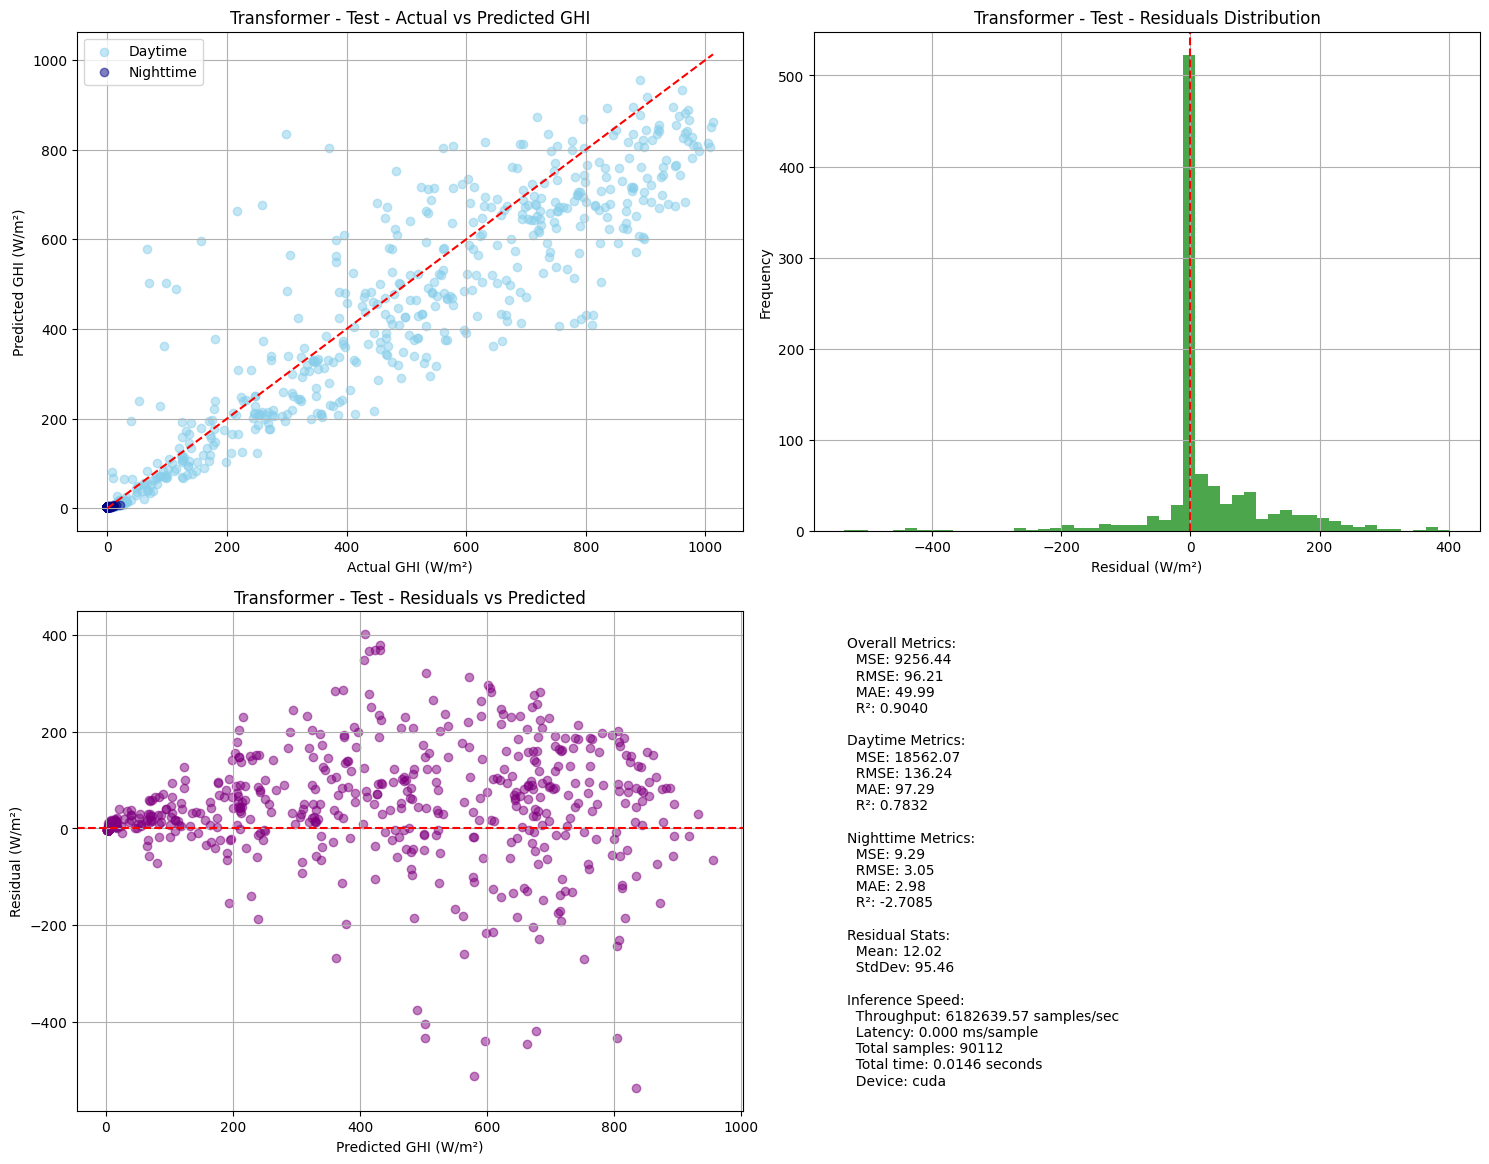

In [22]:
model_name = "Transformer"

# Train the Transformer model
transformer_history, transformer_val_metrics, transformer_test_metrics = run_experiment_pipeline(
    transformer_model,
    train_loader,
    val_loader,
    test_loader,
    model_name=model_name,
    epochs=N_EPOCHS,
    patience=PATIENCE,
    lr=LR * 0.5  # Lower learning rate for transformer
)


### 3.3 Informer Model

The Informer model is a recent advancement in time series forecasting that addresses the limitations of standard Transformer models for long sequence prediction. Key innovations include:

- **ProbSparse Self-attention**: Reduces complexity from O(L²) to O(L log L) where L is sequence length.
- **Self-attention Distilling**: Progressive downsampling of hidden states along the encoder.
- **Generative Decoder**: Enables long sequence prediction with minimal compute.

For solar radiation forecasting, Informer can efficiently capture daily, weekly, and seasonal patterns while focusing computational resources on the most informative timestamps.

In [24]:
from models.informer import InformerModel

# Create Informer model
informer_model = InformerModel(
    input_dim=temporal_dim,           # Dimension of input features
    static_dim=static_dim,            # Dimension of static features
    d_model=128,                      # Model dimension
    n_heads=8,                        # Number of attention heads
    e_layers=3,                       # Number of encoder layers
    d_ff=256,                         # Dimension of feedforward network
    dropout=0.1,                      # Dropout rate
    activation='gelu'                 # Activation function
).to(device)

# Print the model
print_model_info(informer_model)


Model: InformerModel
Total parameters: 411,457
Trainable parameters: 411,457
Non-trainable parameters: 0

Model structure:
InformerModel(
  (enc_embedding): Linear(in_features=8, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (static_proj): Sequential(
    (0):

Training Informer model...
track_experiment: USE_WANDB=True, wandb.run=None, keep_run_open=True
Creating new wandb run for Informer


Epoch 1/100


Epoch 1/100 | Train Loss: 0.0174, Train MAE: 0.0853 | Val Loss: 0.0078, Val MAE: 0.0486 | LR: 0.000150
Epoch 2/100


Epoch 2/100 | Train Loss: 0.0105, Train MAE: 0.0591 | Val Loss: 0.0079, Val MAE: 0.0484 | LR: 0.000150
Epoch 3/100


Epoch 3/100 | Train Loss: 0.0102, Train MAE: 0.0565 | Val Loss: 0.0081, Val MAE: 0.0484 | LR: 0.000150
Epoch 4/100


Epoch 4/100 | Train Loss: 0.0101, Train MAE: 0.0553 | Val Loss: 0.0077, Val MAE: 0.0467 | LR: 0.000150
Epoch 5/100


Epoch 5/100 | Train Loss: 0.0099, Train MAE: 0.0546 | Val Loss: 0.0077, Val MAE: 0.0459 | LR: 0.000150
Epoch 6/100


Epoch 6/100 | Train Loss: 0.0099, Train MAE: 0.0541 | Val Loss: 0.0080, Val MAE: 0.0477 | LR: 0.000150
Epoch 7/100


Epoch 7/100 | Train Loss: 0.0098, Train MAE: 0.0536 | Val Loss: 0.0080, Val MAE: 0.0476 | LR: 0.000150
Epoch 8/100


Epoch 8/100 | Train Loss: 0.0098, Train MAE: 0.0534 | Val Loss: 0.0081, Val MAE: 0.0477 | LR: 0.000150
Epoch 9/100


Epoch 9/100 | Train Loss: 0.0097, Train MAE: 0.0534 | Val Loss: 0.0083, Val MAE: 0.0491 | LR: 0.000150
Epoch 10/100


Epoch 10/100 | Train Loss: 0.0097, Train MAE: 0.0534 | Val Loss: 0.0079, Val MAE: 0.0469 | LR: 0.000150
Epoch 11/100


Epoch 11/100 | Train Loss: 0.0097, Train MAE: 0.0534 | Val Loss: 0.0080, Val MAE: 0.0468 | LR: 0.000075
Epoch 12/100


Epoch 12/100 | Train Loss: 0.0096, Train MAE: 0.0532 | Val Loss: 0.0081, Val MAE: 0.0468 | LR: 0.000075
Epoch 13/100


Epoch 13/100 | Train Loss: 0.0096, Train MAE: 0.0533 | Val Loss: 0.0080, Val MAE: 0.0470 | LR: 0.000075
Epoch 14/100


Epoch 14/100 | Train Loss: 0.0096, Train MAE: 0.0533 | Val Loss: 0.0082, Val MAE: 0.0474 | LR: 0.000075
Epoch 15/100


Epoch 15/100 | Train Loss: 0.0096, Train MAE: 0.0533 | Val Loss: 0.0081, Val MAE: 0.0469 | LR: 0.000075
Early stopping at epoch 15
LOADING BEST MODEL FROM TRAINING SESSION
Keeping wandb run open as requested (keep_run_open=True)


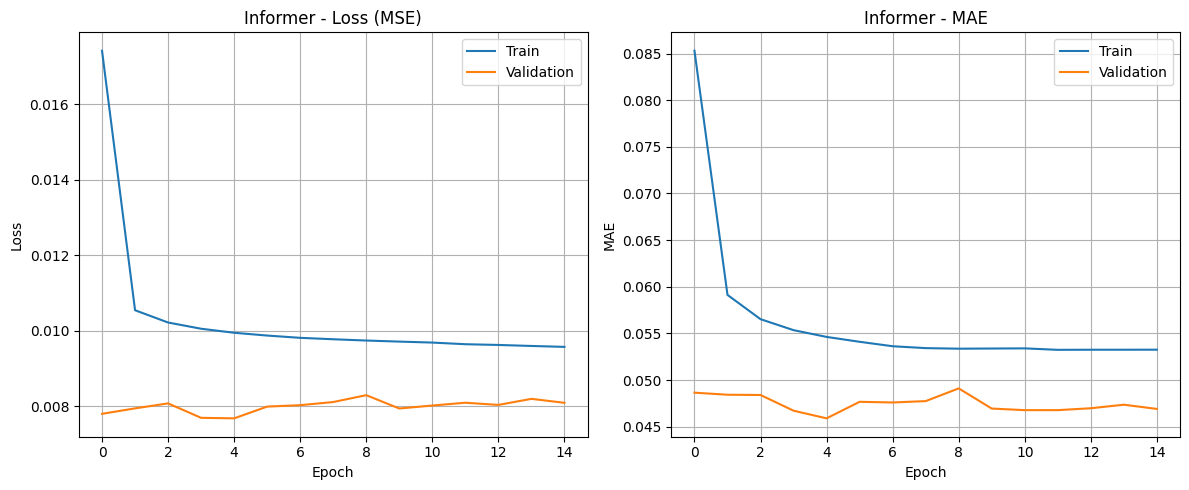

Evaluating Informer model on validation set...

Informer - Validation Evaluation Metrics:
  Overall:  MSE: 9719.13, RMSE: 98.59, MAE: 51.39, R²: 0.8977
  Daytime:  MSE: 19475.79, RMSE: 139.56, MAE: 101.84, R²: 0.7655
  Nighttime: MSE: 2.66, RMSE: 1.63, MAE: 1.14, R²: -0.0480
  Inference Speed: 13070412.63 samples/sec, 0.0001 ms/sample
  Total time: 0.0138 sec for 180224 samples

Evaluating Informer model on test set...

Informer - Test Evaluation Metrics:
  Overall:  MSE: 8821.79, RMSE: 93.92, MAE: 48.37, R²: 0.9074
  Daytime:  MSE: 17681.67, RMSE: 132.97, MAE: 95.81, R²: 0.7921
  Nighttime: MSE: 2.73, RMSE: 1.65, MAE: 1.14, R²: -0.1092
  Inference Speed: 14666839.56 samples/sec, 0.0001 ms/sample
  Total time: 0.0123 sec for 180224 samples


test/inference_speed_samples_per_sec,▁
test/inference_time_ms_per_sample,▁
test/mae,▁
test/mse,▁
test/r2,▁
test/rmse,▁
train/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train/learning_rate,██████████▁▁▁▁▁
train/loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


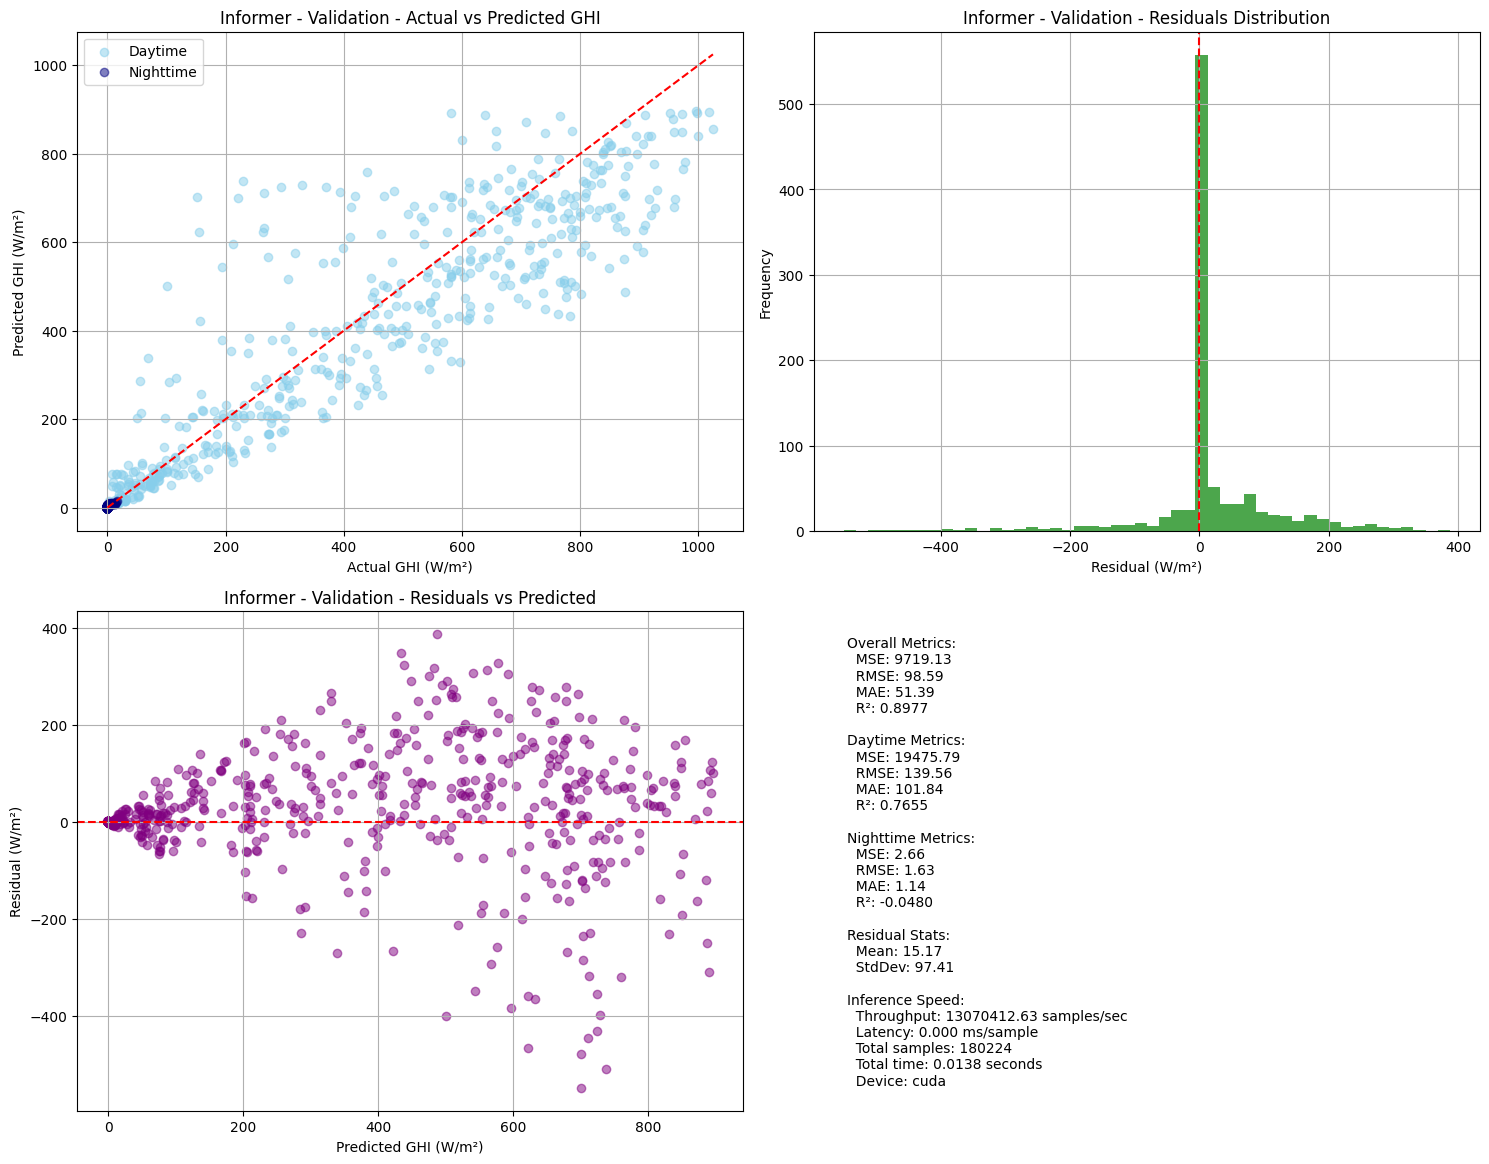

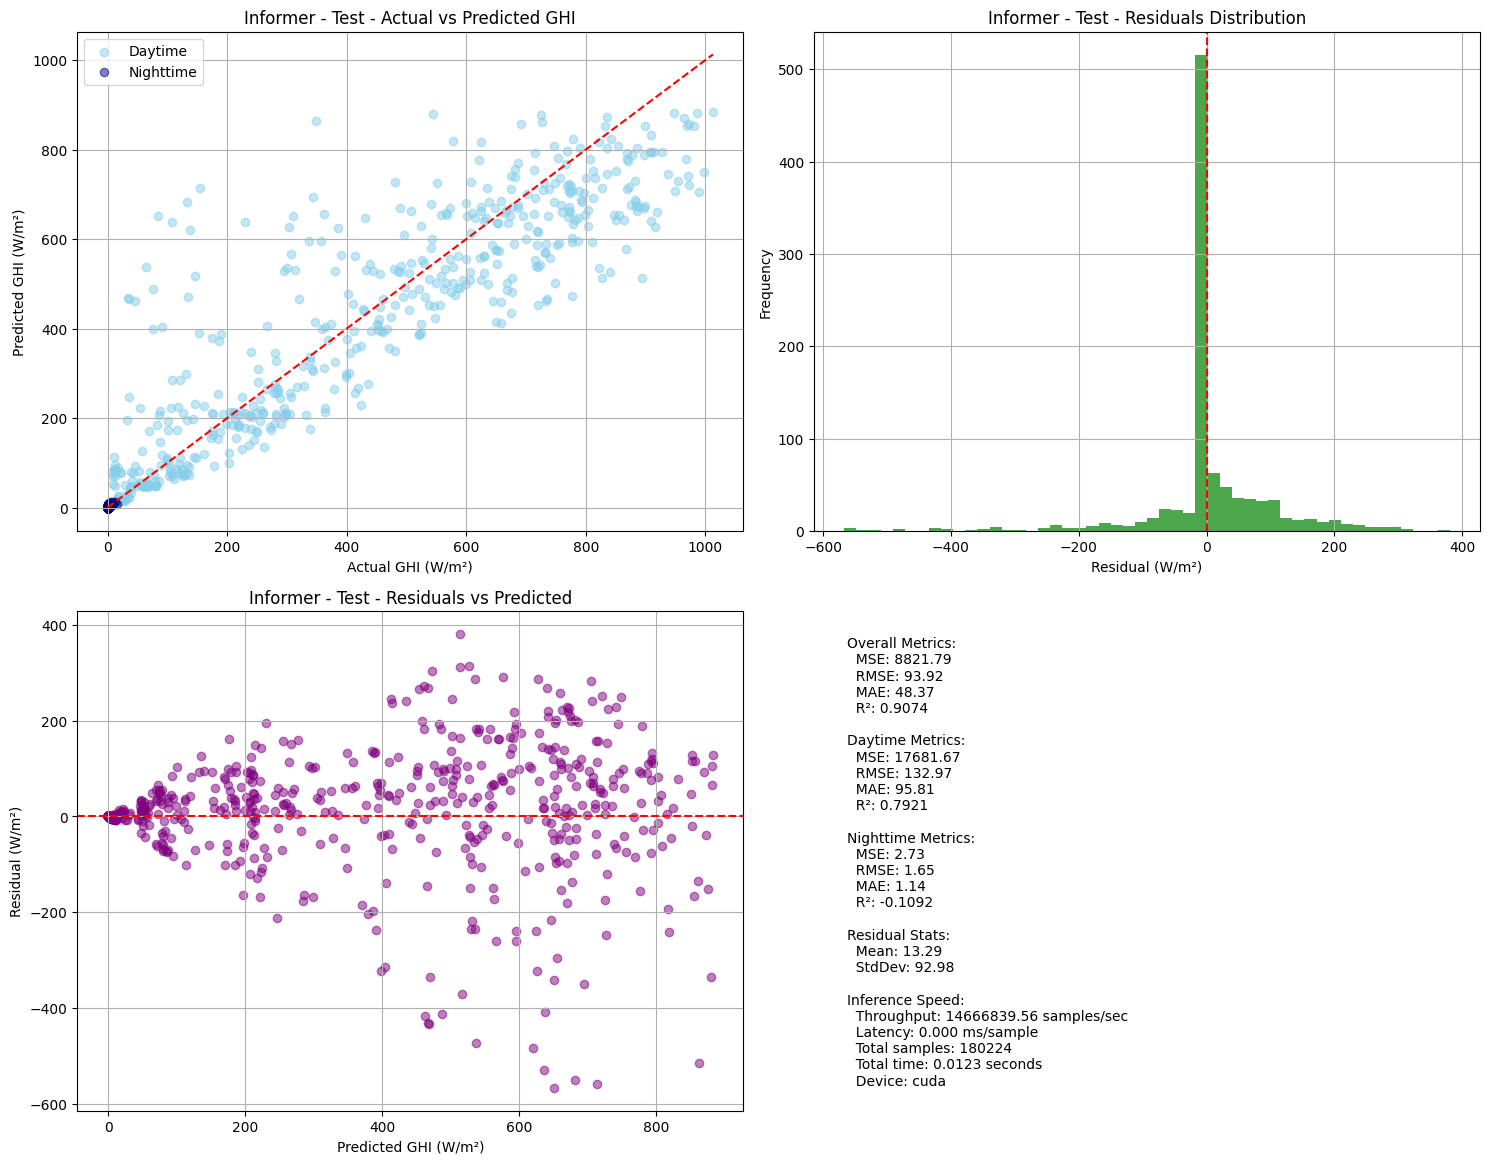

In [25]:
model_name = "Informer"

# Train the Informer model with a lower learning rate
informer_history, informer_val_metrics, informer_test_metrics = run_experiment_pipeline(
    informer_model,
    train_loader,
    val_loader,
    test_loader,
    model_name=model_name,
    epochs=N_EPOCHS,
    patience=PATIENCE,
    lr=LR * 0.3  # Lower learning rate for Informer
)


## 4. Model Comparison

## 4.1 Compare Models' Performance


Test Set Comparison:

Model Comparison - Test Set Set:
                        TCN     Transformer         Informer
MSE             8903.996094     9256.443359      8821.794922
RMSE              94.360988       96.210412        93.924411
MAE               48.509155       49.986729         48.36731
R²                 0.906507        0.903984          0.90737
Samples/sec  9755494.464755  6182639.567624  14666839.560255
ms/sample          0.000103        0.000162         0.000068
Input DataFrame for visualization:
                        TCN     Transformer         Informer
MSE             8903.996094     9256.443359      8821.794922
RMSE              94.360988       96.210412        93.924411
MAE               48.509155       49.986729         48.36731
R²                 0.906507        0.903984          0.90737
Samples/sec  9755494.464755  6182639.567624  14666839.560255
ms/sample          0.000103        0.000162         0.000068
Model names: ['TCN', 'Transformer', 'Informer']
Scaling

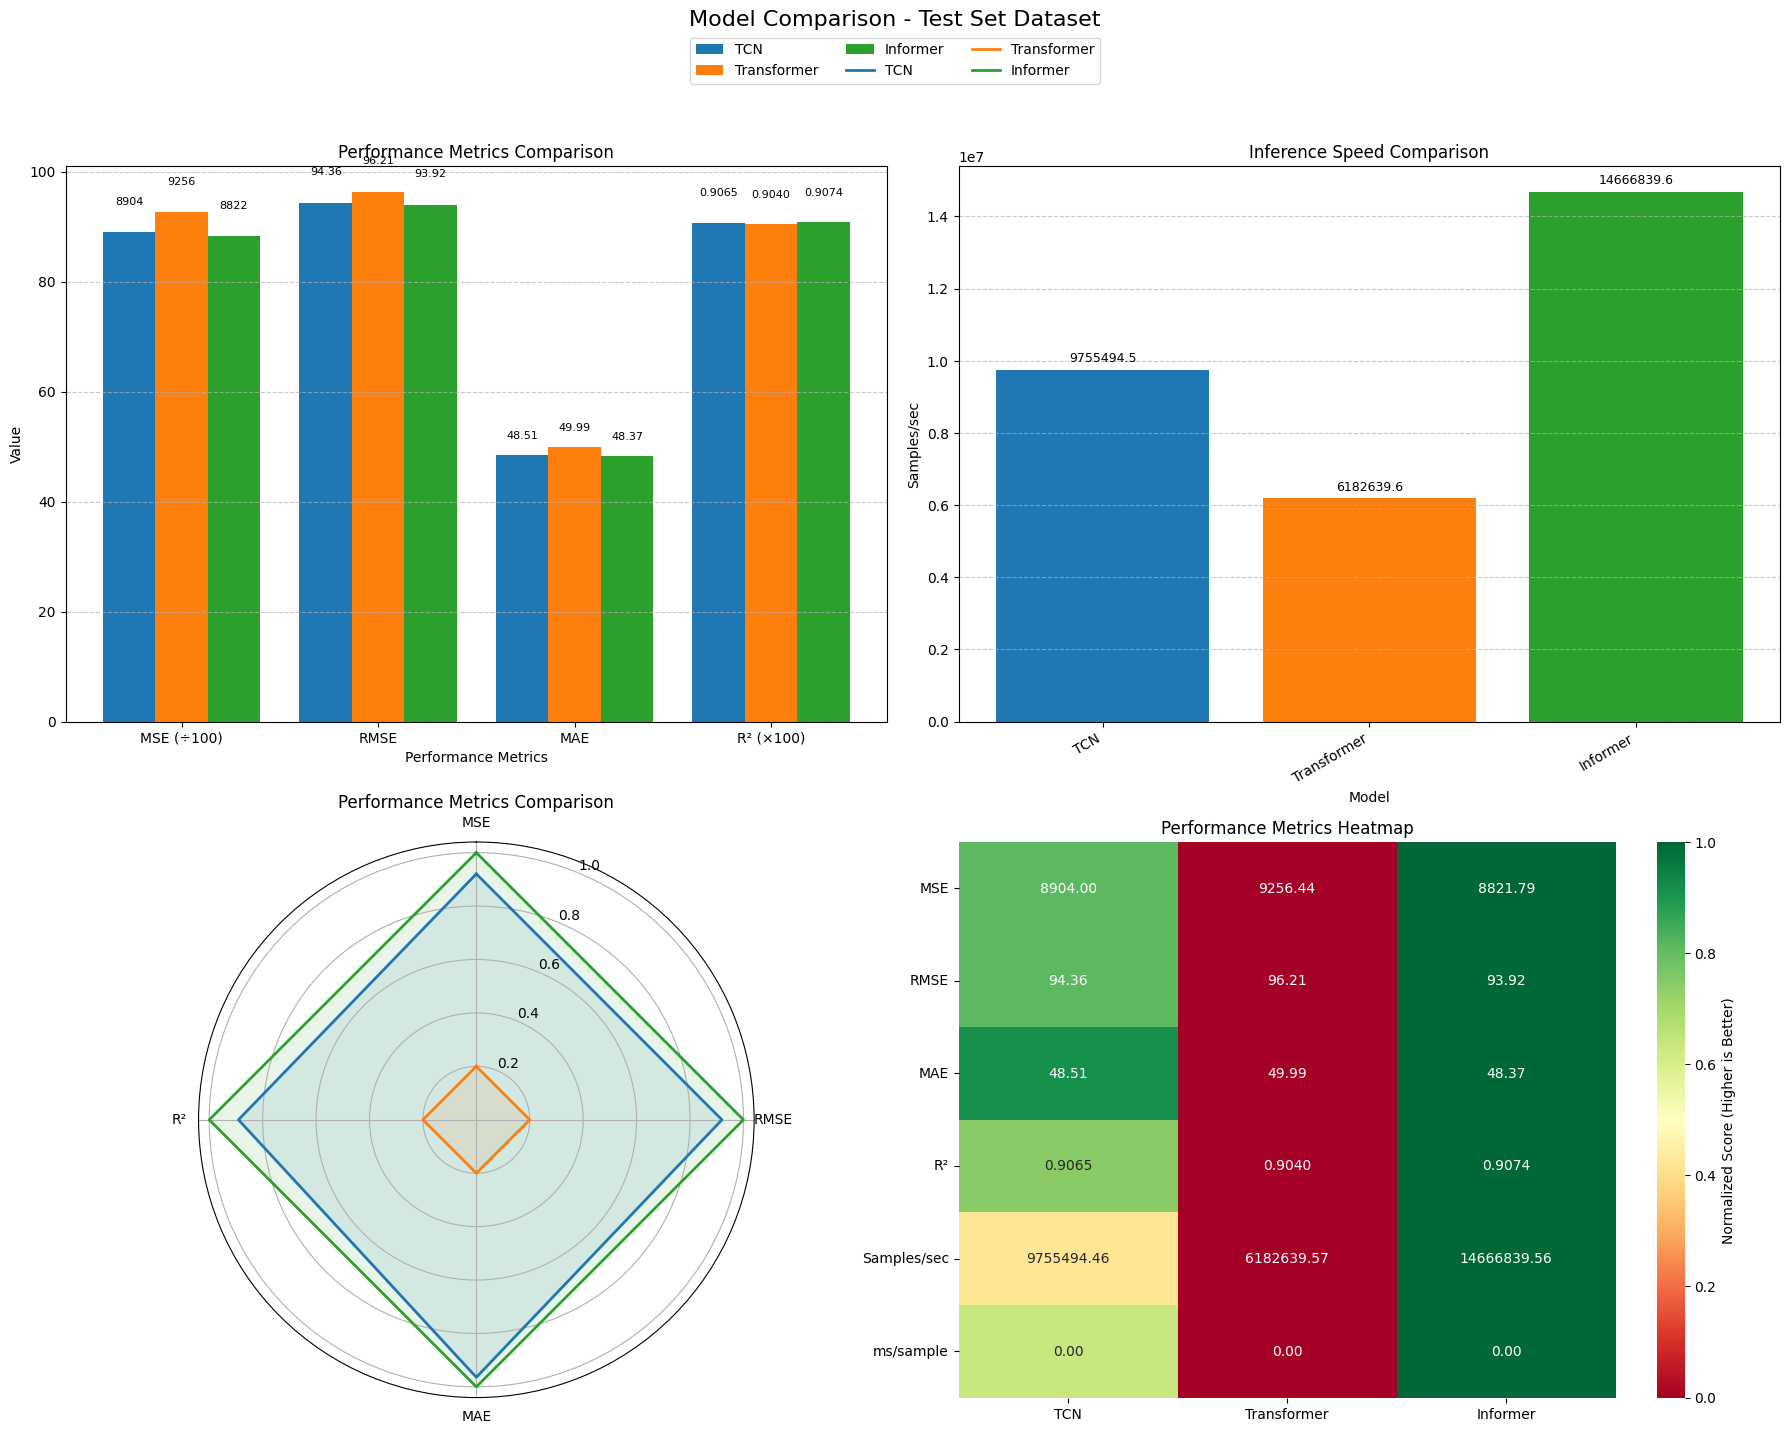

(                        TCN     Transformer         Informer
 MSE             8903.996094     9256.443359      8821.794922
 RMSE              94.360988       96.210412        93.924411
 MAE               48.509155       49.986729         48.36731
 R²                 0.906507        0.903984          0.90737
 Samples/sec  9755494.464755  6182639.567624  14666839.560255
 ms/sample          0.000103        0.000162         0.000068,
 <Figure size 1800x2100 with 5 Axes>)

In [26]:
from utils.plot_utils import compare_models

# Create a dictionary of model metrics
model_metrics = {
    'TCN': tcn_test_metrics,
    'Transformer': transformer_test_metrics,
    'Informer': informer_test_metrics
}

# Compare model performance on test set
print("\nTest Set Comparison:")
compare_models(model_metrics, dataset_name='Test Set')


## 4.2 Model Comparison on Daytime/Nighttime/Overall

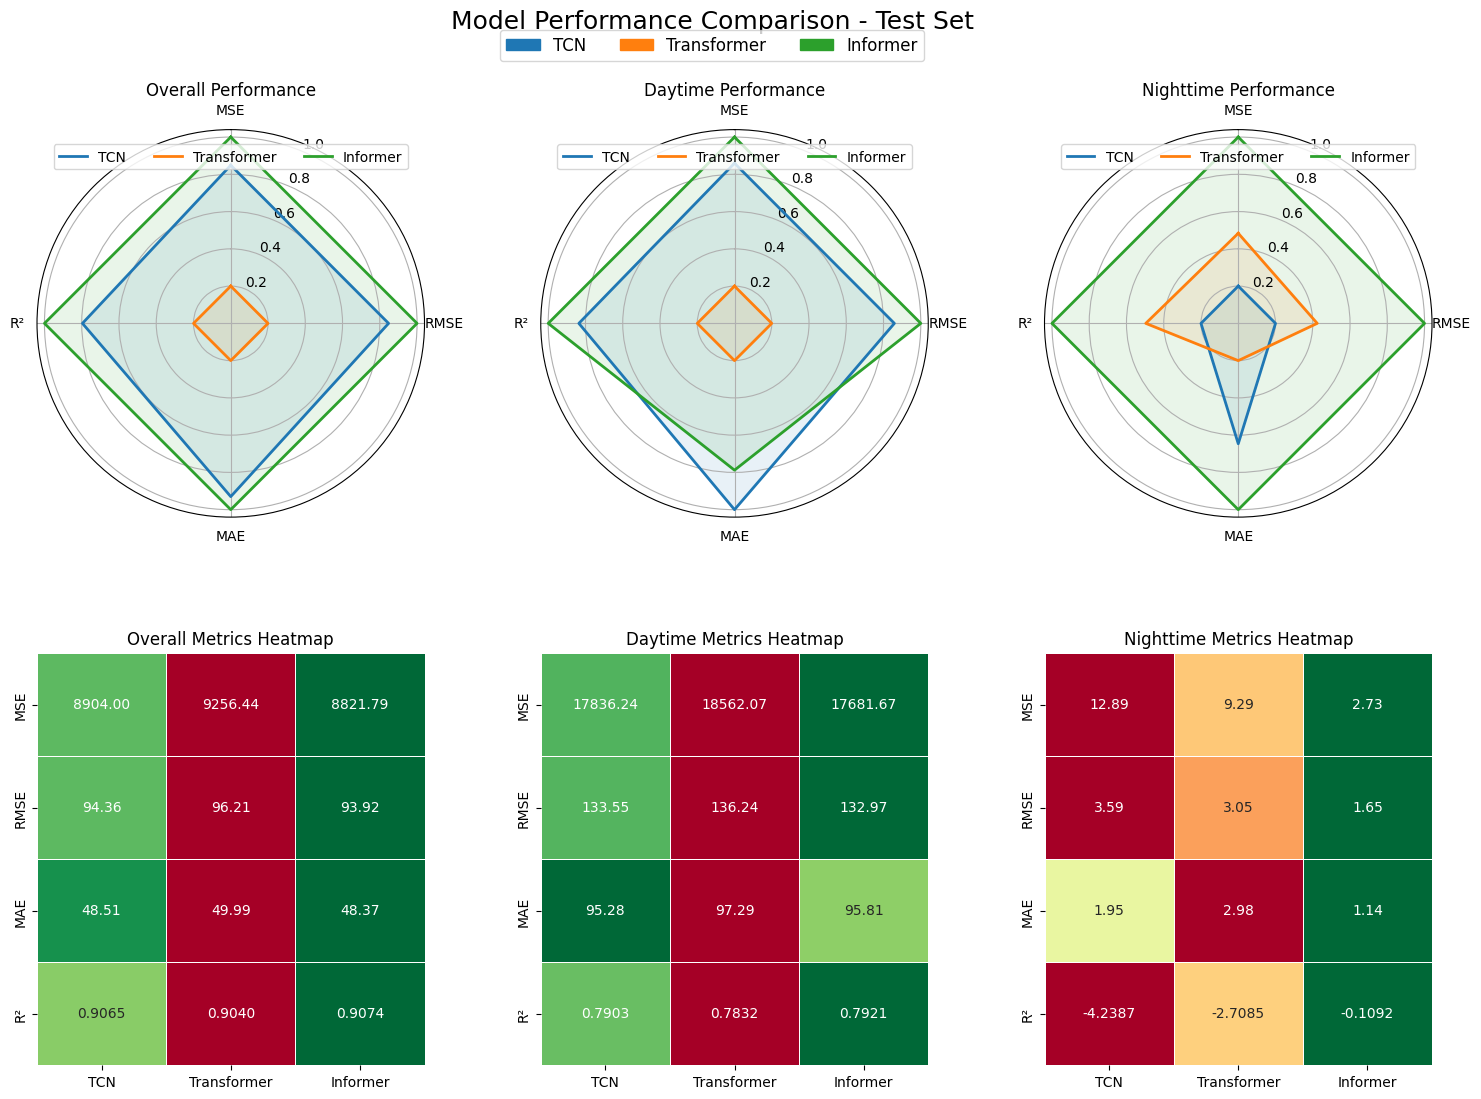

In [27]:
from utils.plot_utils import compare_models_daytime_nighttime

# Create a dictionary of model metrics
model_metrics = {
    'TCN': tcn_test_metrics,
    'Transformer': transformer_test_metrics,
    'Informer': informer_test_metrics
}

# Generate the comparison plot
comparison_fig = compare_models_daytime_nighttime(model_metrics, dataset_name='Test Set')


## 5. Train and Evaluate Models

### 5.2 Time Series Predictions

Visualize predictions over time.

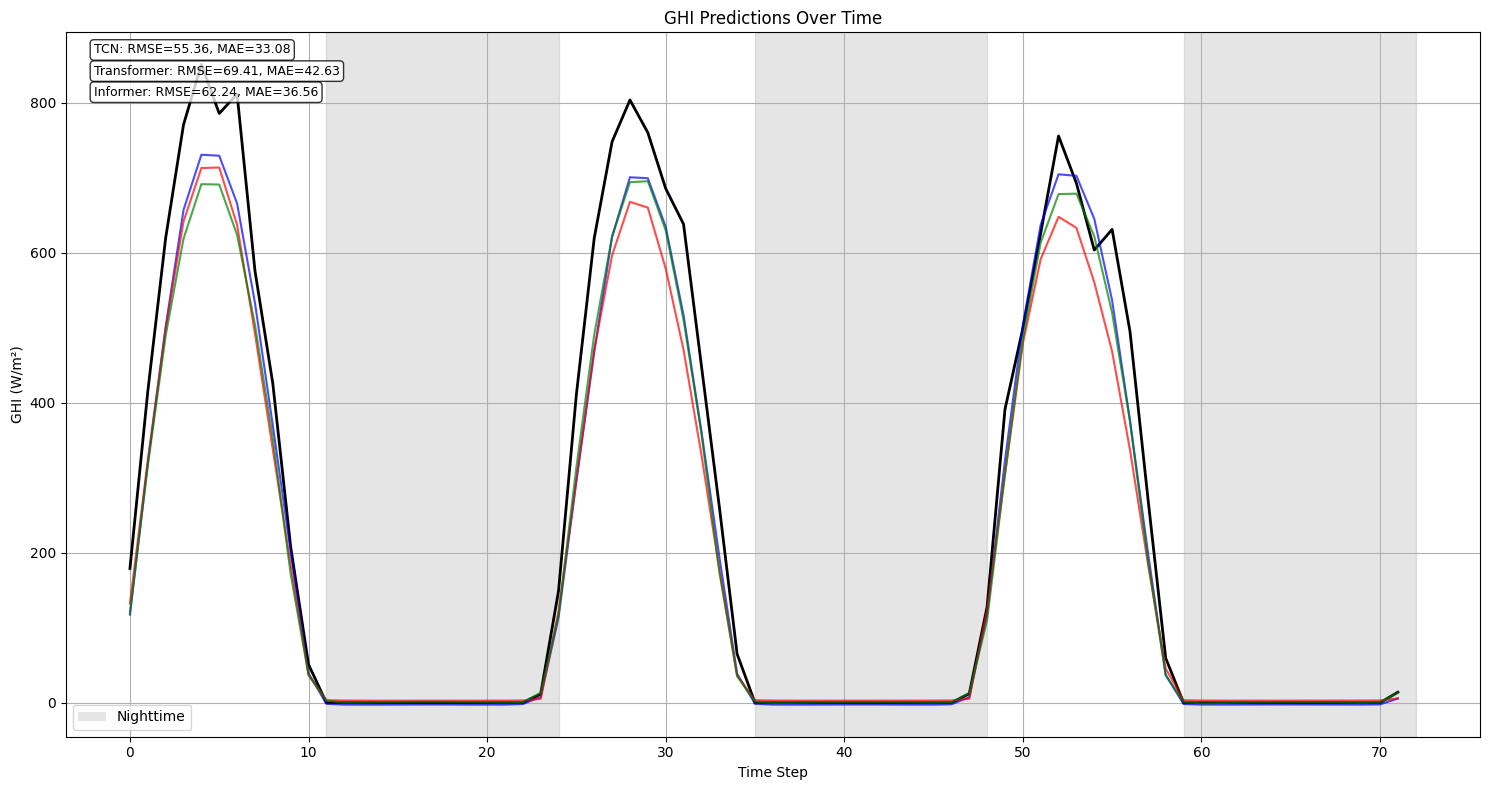

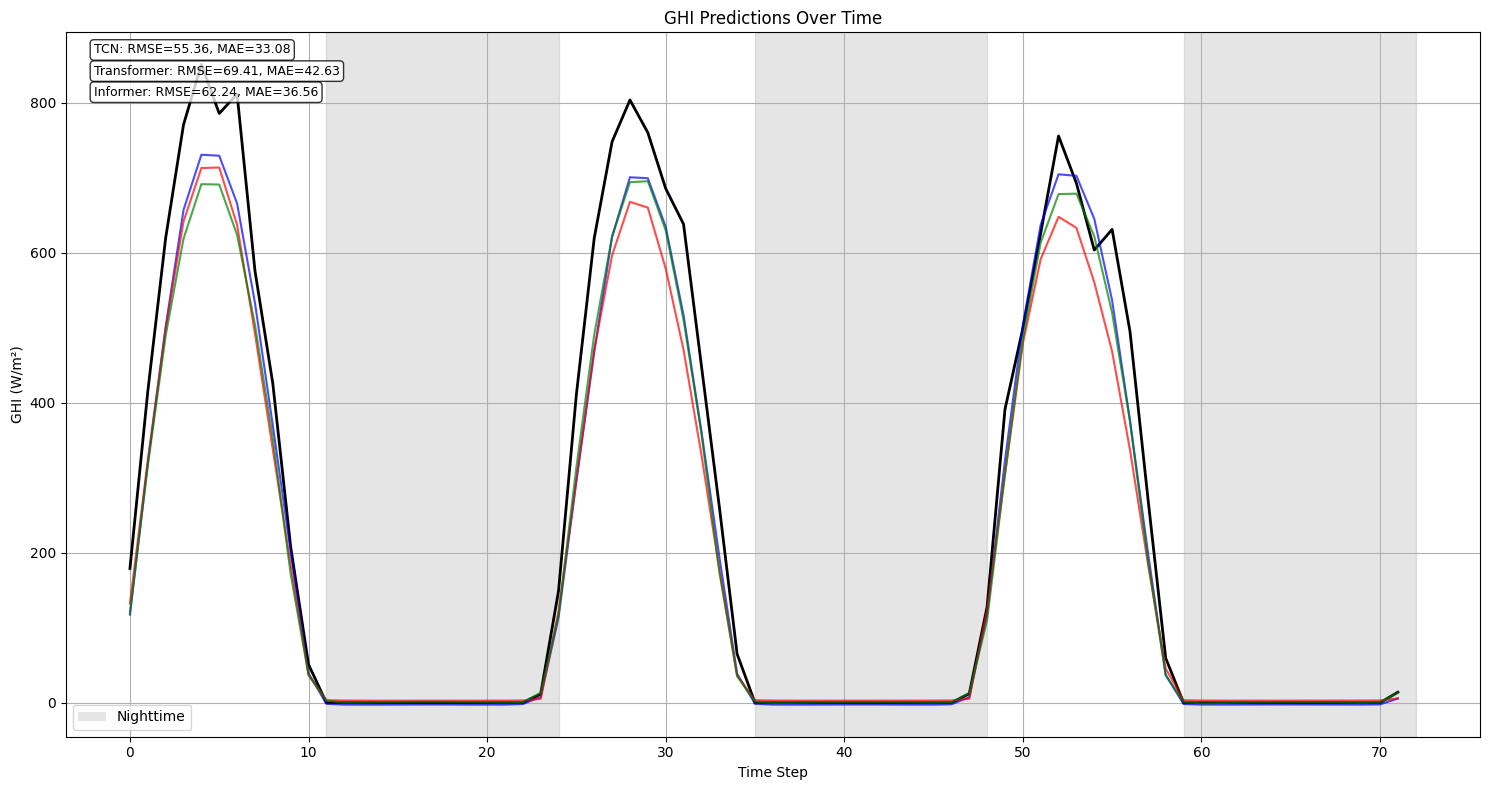

In [28]:
def plot_predictions_over_time(models, model_names, data_loader, target_scaler, num_samples=200, start_idx=0):
    """
    Plot time series predictions for multiple models with nighttime shading if available

    Args:
        models: List of PyTorch models
        model_names: List of model names
        data_loader: Data loader
        target_scaler: Scaler for the target variable
        num_samples: Number of consecutive time steps to plot
        start_idx: Starting index in the dataset
    """
    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch

    # Get device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Collect data samples
    all_batches = []
    for batch in data_loader:
        all_batches.append(batch)
        if len(all_batches) * batch['target'].shape[0] > start_idx + num_samples:
            break

    # Combine batches into a single dataset
    all_temporal = []
    all_static = []
    all_targets = []
    all_nighttime = []
    has_nighttime = False

    for batch in all_batches:
        all_temporal.append(batch['temporal_features'])
        all_static.append(batch['static_features'])
        all_targets.append(batch['target'])
        # Check if nighttime data is available
        if 'nighttime' in batch:
            has_nighttime = True
            all_nighttime.append(batch['nighttime'])

    all_temporal = torch.cat(all_temporal, dim=0)
    all_static = torch.cat(all_static, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    if has_nighttime:
        all_nighttime = torch.cat(all_nighttime, dim=0)

    # Get the subset for visualization
    temporal = all_temporal[start_idx:start_idx+num_samples].to(device)
    static = all_static[start_idx:start_idx+num_samples].to(device)
    targets = all_targets[start_idx:start_idx+num_samples].cpu().numpy()

    if has_nighttime:
        nighttime = all_nighttime[start_idx:start_idx+num_samples].cpu().numpy()
        # Ensure nighttime is a 1D array
        if len(nighttime.shape) > 1:
            nighttime = nighttime.flatten() if nighttime.shape[1] == 1 else nighttime[:,0]

    # Generate predictions
    predictions = []
    for model in models:
        model.eval()
        with torch.no_grad():
            outputs = model(temporal, static).cpu().numpy()
            predictions.append(outputs)

    # Inverse transform to original scale
    y_true_orig = target_scaler.inverse_transform(targets.reshape(-1, 1)).flatten()
    y_pred_orig_list = [target_scaler.inverse_transform(pred.reshape(-1, 1)).flatten() for pred in predictions]

    # Create visualization
    fig = plt.figure(figsize=(15, 8))
    ax = plt.gca()

    # If we have nighttime data, shade those regions
    if has_nighttime:
        # Create mask for continuous nighttime periods
        nighttime_bool = (nighttime > 0.5)

        # Shade nighttime regions
        night_regions = []
        start = None
        for i, is_night in enumerate(nighttime_bool):
            if is_night and start is None:
                start = i
            elif not is_night and start is not None:
                night_regions.append((start, i))
                start = None

        # Handle case where the last region is nighttime
        if start is not None:
            night_regions.append((start, len(nighttime_bool)))

        # Plot nighttime regions
        for start, end in night_regions:
            ax.axvspan(start, end, alpha=0.2, color='gray', label='_nolegend_')

        # Only add nighttime to the legend once
        if night_regions:
            # Add dummy entry for nighttime legend
            handles, labels = ax.get_legend_handles_labels()
            handles.append(Patch(facecolor='gray', alpha=0.2))
            labels.append('Nighttime')
            ax.legend(handles, labels)

    # Plot predictions
    plt.plot(y_true_orig, 'k-', label='Actual GHI', linewidth=2)

    colors = ['b-', 'r-', 'g-', 'm-', 'c-', 'y-']
    for i, (pred, name) in enumerate(zip(y_pred_orig_list, model_names)):
        plt.plot(pred, colors[i % len(colors)], label=f'{name} Predicted', alpha=0.7)

    # Calculate and display error metrics for the visualization window
    for i, (pred, name) in enumerate(zip(y_pred_orig_list, model_names)):
        rmse = np.sqrt(np.mean((y_true_orig - pred) ** 2))
        mae = np.mean(np.abs(y_true_orig - pred))

        # Add metrics annotation
        plt.annotate(f"{name}: RMSE={rmse:.2f}, MAE={mae:.2f}",
                     xy=(0.02, 0.97 - 0.03*i),
                     xycoords='axes fraction',
                     fontsize=9,
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    plt.title('GHI Predictions Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('GHI (W/m²)')

    # If we haven't added a legend yet (no nighttime data), add it now
    if not has_nighttime or not night_regions:
        plt.legend(loc='upper right')

    plt.grid(True)
    plt.tight_layout()

    return fig

# Plot time series predictions
plot_predictions_over_time(
    models=[tcn_model, transformer_model, informer_model],
    model_names=['TCN', 'Transformer', 'Informer'],
    data_loader=test_loader,
    target_scaler=scalers[f'{TARGET_VARIABLE}_scaler'],
    num_samples=72,
    start_idx=0
)
